<a href="https://colab.research.google.com/github/RevanthBN/COVID-GANs/blob/main/COVID_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import all you can!**

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.pyplot import *
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import os
from PIL import Image
import torchvision.transforms.functional as TF
import time
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
cuda = torch.cuda.is_available()
from torch.autograd import Variable
from torchvision.utils import save_image# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cuda
!pip install torchsummary
from torchsummary import summary
import matplotlib.animation as animation
from IPython.display import HTML
import torchvision.utils as vutils

In [5]:

! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! pip install --upgrade --force-reinstall --no-deps kaggle

ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
alexgude/california-traffic-collision-data-from-switrs       California Traffic Collision Data from SWITRS    1GB  2020-11-22 16:51:55            550  
babyoda/women-entrepreneurship-and-labor-force               Women Entrepreneurship and Labor Force           1KB  2020-11-21 08:38:51           1693  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57            727  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44           3151  
imoore/2020-us-general-election-turnout-rates                2020 US General Election Tu

In [ ]:
# ! kaggle competitions download -c yash612/covidnet-mini-and-gan-enerated-chest-xray
! kaggle datasets download -d yash612/covidnet-mini-and-gan-enerated-chest-xray
! unzip covidnet-mini-and-gan-enerated-chest-xray.zip -d data

**Hyperparameters**

- dataroot - the path to the root of the dataset folder. We will talk more about the dataset in the next section
- workers - the number of worker threads for loading the data with the DataLoader
- batch_size - the batch size used in training. The DCGAN paper uses a batch size of 128
- image_size - the spatial size of the images used for training. This implementation defaults to 64x64. If another size is desired, the structures of D and G must be changed. See here for more details
- nc - number of color channels in the input images. For color images this is 3
- nz - length of latent vector
- ngf - relates to the depth of feature maps carried through the generator
- ndf - sets the depth of feature maps propagated through the discriminator
num_epochs - number of training epochs to run. Training for longer will probably lead to better results but will also take much longer
- lr - learning rate for training. As described in the DCGAN paper, this number should be 0.0002
- beta1 - beta1 hyperparameter for Adam optimizers. As described in paper, this number should be 0.5
- ngpu - number of GPUs available. If this is 0, code will run in CPU mode. If this number is greater than 0 it will run on that number of GPUs

In [64]:
# # Root directory for dataset
# dataroot = "data/celeba"

# Number of workers for dataloader
num_workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

**Apply transformation on the images**

In [61]:
trans_apply=transforms.Compose([transforms.Resize((image_size,image_size)),transforms.ToTensor(),transforms.Normalize((0, 0, 0), (0.5, 0.5, 0.5))])
train_dataset=datasets.ImageFolder('data/chest_xray/chest_xray/train',transform=trans_apply)
val_dataset=datasets.ImageFolder('data/chest_xray/chest_xray/val',transform=trans_apply)
test_dataset=datasets.ImageFolder('data/chest_xray/chest_xray/test',transform=trans_apply)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 64, 64])
3


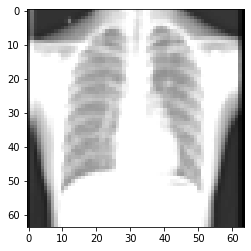

In [62]:
plt.imshow(np.transpose(test_dataset[100][0],axes=(1,2,0)))
print(train_dataset[1600][0].shape)
print(len(train_dataset.classes))
n_classes=len(train_dataset.classes)

In [63]:
print("train",train_dataset.__len__(), len(train_dataset.classes))
print("val",val_dataset.__len__(), len(val_dataset.classes))
print("test",test_dataset.__len__(), len(test_dataset.classes))

train 5882 3
val 27 3
test 635 3


**Data Loader**

In [65]:
# num_workers = 4 if cuda else 0 
    
# Training data
train_loader_args = dict(shuffle=True, batch_size=100, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=800)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

# Validation data
val_loader_args = dict(shuffle=True, batch_size=10, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=500)
val_loader = data.DataLoader(val_dataset, **val_loader_args)

# Testing data
test_loader_args = dict(shuffle=False, num_workers=num_workers) if cuda\
                    else dict(shuffle=False,drop_last=True)
test_loader = data.DataLoader(test_dataset, **test_loader_args)


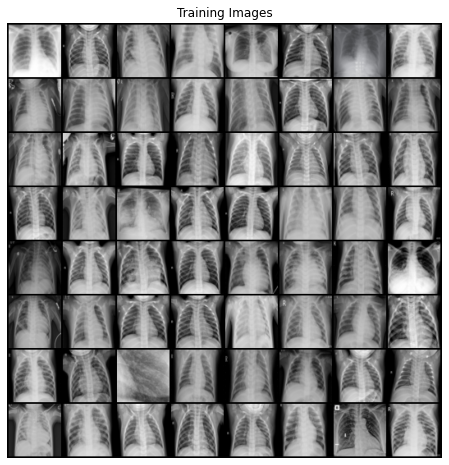

In [66]:
# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

**DC GANs Model**

**Weight Initialization**

In [54]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

**Generator - Model**

In [67]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [68]:
#Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


**Discriminator Model**

In [69]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [70]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


**Loss Functions and Optimizers**

In [71]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

**Training the GANs Model**

In [75]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/10][0/59]	Loss_D: 0.0000	Loss_G: 37.8032	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/10][50/59]	Loss_D: 0.0000	Loss_G: 37.7511	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/10][0/59]	Loss_D: 0.0000	Loss_G: 37.6017	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/10][50/59]	Loss_D: 0.0000	Loss_G: 37.4586	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/10][0/59]	Loss_D: 0.0000	Loss_G: 37.1959	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2/10][50/59]	Loss_D: 0.0000	Loss_G: 36.4245	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/10][0/59]	Loss_D: 0.0000	Loss_G: 36.1483	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[3/10][50/59]	Loss_D: 1.5472	Loss_G: 29.1779	D(x): 0.9998	D(G(z)): 0.5768 / 0.0000
[4/10][0/59]	Loss_D: 0.0008	Loss_G: 20.7890	D(x): 0.9992	D(G(z)): 0.0000 / 0.0000
[4/10][50/59]	Loss_D: 1.8434	Loss_G: 5.6055	D(x): 0.8223	D(G(z)): 0.7017 / 0.0075
[5/10][0/59]	Loss_D: 2.1664	Loss_G: 3.9627	D(x): 0.2408	D(G(z)): 0.0091 / 0.0230
[5/10][50/59]	Loss_D: 1.1709	Loss_G: 3.8270	D(x): 0.7536	D(G(z)): 0.4

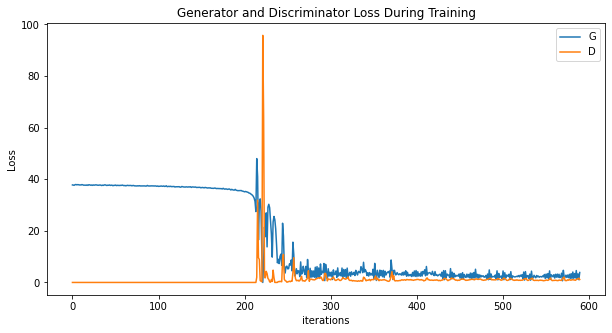

In [76]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Generator's Progression**

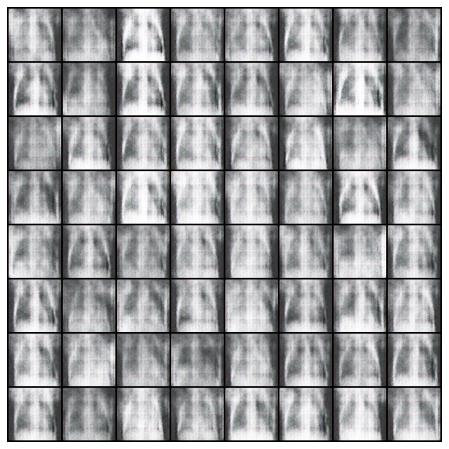

In [77]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

**Real vs Fake**

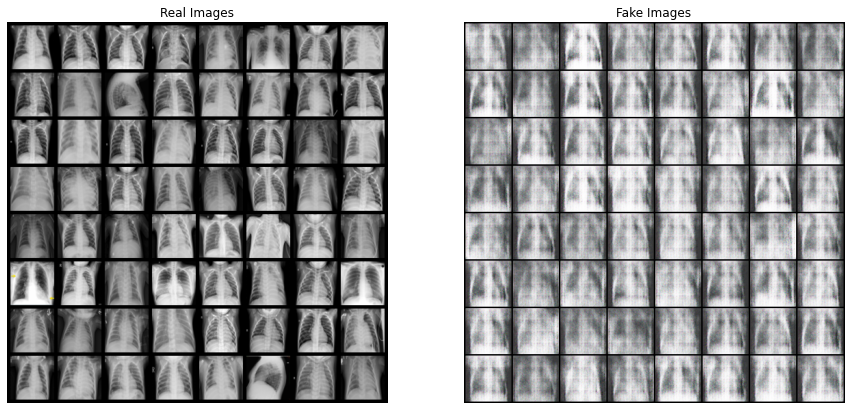

In [79]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()